In [1]:
import numpy as np
import bagpipes as pipes
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import astropy.cosmology as cosmology
import math

In [2]:
def get_cog(rad, intens, axis_ratio=1.0):
    """Measure curve of growth."""
    # Area within each aperture
    assert rad.shape == intens.shape
    aper_area = np.pi * axis_ratio * (rad ** 2)
    return np.nancumsum(np.append(aper_area[0], np.diff(aper_area)) * intens)

[Extinction coefficients](https://www.legacysurvey.org/dr10/catalogs/) for the three bands

In [3]:
r_band = {'g': 3.214, 'r': 2.165, 'i': 1.592, 'z': 1.211}

In [4]:
def load_phot(ID):
    path='/Users/evrinezhang/anaconda3/envs/dap/lib/python3.9/site-packages/mangadap/data/remote/'
    row=int(ID)
    rmax = 17.075  # Rmax for MaNGA data cube
    hdu = fits.open(path+'IC0846-largegalaxy-1113718-ellipse.fits')
    hdap = fits.open(path+'manga-11010-12701-MAPS-SPX-MILESHC-MASTARSSP.fits.gz')
    ebv = hdap[0].header['EBVGAL']
    eps_r = np.copy(hdu[1].data['R_EPS'][0])[1]
    #from nanomaggies to AB magnitude
    sga_grz=np.array([22.5 - 2.5 * np.log10(hdu[1].data['G_INTENS'][0]) - r_band['g'] * ebv,
             22.5 - 2.5 * np.log10(hdu[1].data['R_INTENS'][0]) - r_band['r'] * ebv,
             22.5 - 2.5 * np.log10(hdu[1].data['Z_INTENS'][0]) - r_band['z'] * ebv])
    sga_err=np.array([22.5 - 2.5 * np.log10(hdu[1].data['G_INTENS_ERR'][0]) - r_band['g'] * ebv,
            22.5 - 2.5 * np.log10(hdu[1].data['R_INTENS_ERR'][0]) - r_band['r'] * ebv,
            22.5 - 2.5 * np.log10(hdu[1].data['Z_INTENS_ERR'][0]) - r_band['z'] * ebv])
    #unit transform to microjanskys
    sga_grz = 10 ** ((23.9 - sga_grz) / 2.5)    
    sga_err = 10 ** ((23.9 - sga_err) / 2.5)
    dx = hdu[1].data['R_SMA'][0] * 0.263
    flux = np.array([get_cog(dx / 0.263, sga_grz[0], axis_ratio=1 - eps_r) * 0.263 ** 2,
                     get_cog(dx / 0.263, sga_grz[1], axis_ratio=1 - eps_r) * 0.263 ** 2,
                     get_cog(dx / 0.263, sga_grz[2], axis_ratio=1 - eps_r) * 0.263 ** 2])
    err = np.array([get_cog(dx / 0.263, sga_err[0], axis_ratio=1 - eps_r) * 0.263 ** 2,
                    get_cog(dx / 0.263, sga_err[1], axis_ratio=1 - eps_r) * 0.263 ** 2,
                    get_cog(dx / 0.263, sga_err[2], axis_ratio=1 - eps_r) * 0.263 ** 2])
    phot_f = flux[:,row]
    phot_e = err[:,row]
    photometry = np.c_[phot_f, phot_e]
    return photometry

In [5]:
goodss_filt_list = np.loadtxt("filters/goodss_filt_list2.txt", dtype="str")

In [6]:
galaxy = pipes.galaxy('200', load_phot, spectrum_exists=False, filt_list=goodss_filt_list)

/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_58568/1022652423.py:10: RuntimeWarning: invalid value encountered in log10
  sga_grz=np.array([22.5 - 2.5 * np.log10(hdu[1].data['G_INTENS'][0]) - r_band['g'] * ebv,
/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_58568/1022652423.py:11: RuntimeWarning: invalid value encountered in log10
  22.5 - 2.5 * np.log10(hdu[1].data['R_INTENS'][0]) - r_band['r'] * ebv,
/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_58568/1022652423.py:12: RuntimeWarning: invalid value encountered in log10
  22.5 - 2.5 * np.log10(hdu[1].data['Z_INTENS'][0]) - r_band['z'] * ebv])
/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_58568/1022652423.py:13: RuntimeWarning: divide by zero encountered in log10
  sga_err=np.array([22.5 - 2.5 * np.log10(hdu[1].data['G_INTENS_ERR'][0]) - r_band['g'] * ebv,
/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_58568/1022652423.py:14: RuntimeWarning: divide by zero encountered in l

# Construct fit instructions

In [7]:
delayed = {"age": (0.1, 15.),
           "tau": (0.01, 5.),
           "massformed": (7., 15.),
           "metallicity": (0., 2.5)}

In [8]:
dust = {"type": "Calzetti", "Av": (0., 2.)}

In [9]:
fit_info = {"redshift": (0,2), "redshift_prior": "Gaussian", "redshift_prior_mu": 0.02,
            "redshift_prior_sigma": 0.02}

In [10]:
fit_info["delayed"] = delayed
fit_info["dust"] = dust
fit_info["veldisp"] = (0.500)

In [11]:
fit = pipes.fit(galaxy, fit_info)

# Fitting

In [12]:
fit.fit(verbose=False)


Bagpipes: fitting object 200

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************

Completed in 72.2 seconds.
 ln(ev)=   94.715961503091364      +/-  0.15142268372873979     
 Total Likelihood Evaluations:        26870
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    5.580      9.423     11.771
delayed:massformed            10.966     11.301     11.614
delayed:metallicity            0.226      0.595      1.510
delayed:tau                    0.342      0.886      1.664
dust:Av                        0.100      0.325      0.776
redshift                 

# Plots

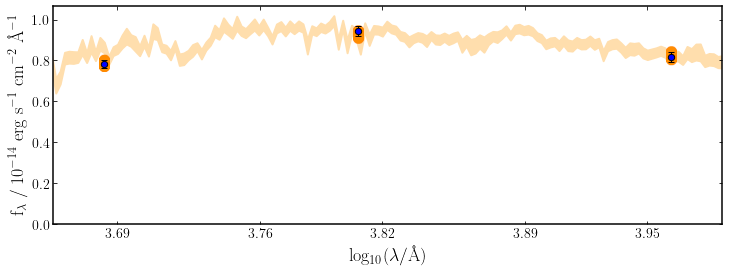

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\mathrm{log_{10}}\\big(\\lambda / \\mathrm{\\AA}\\big)$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-14}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [13]:
fit.plot_spectrum_posterior(save=False, show=True)

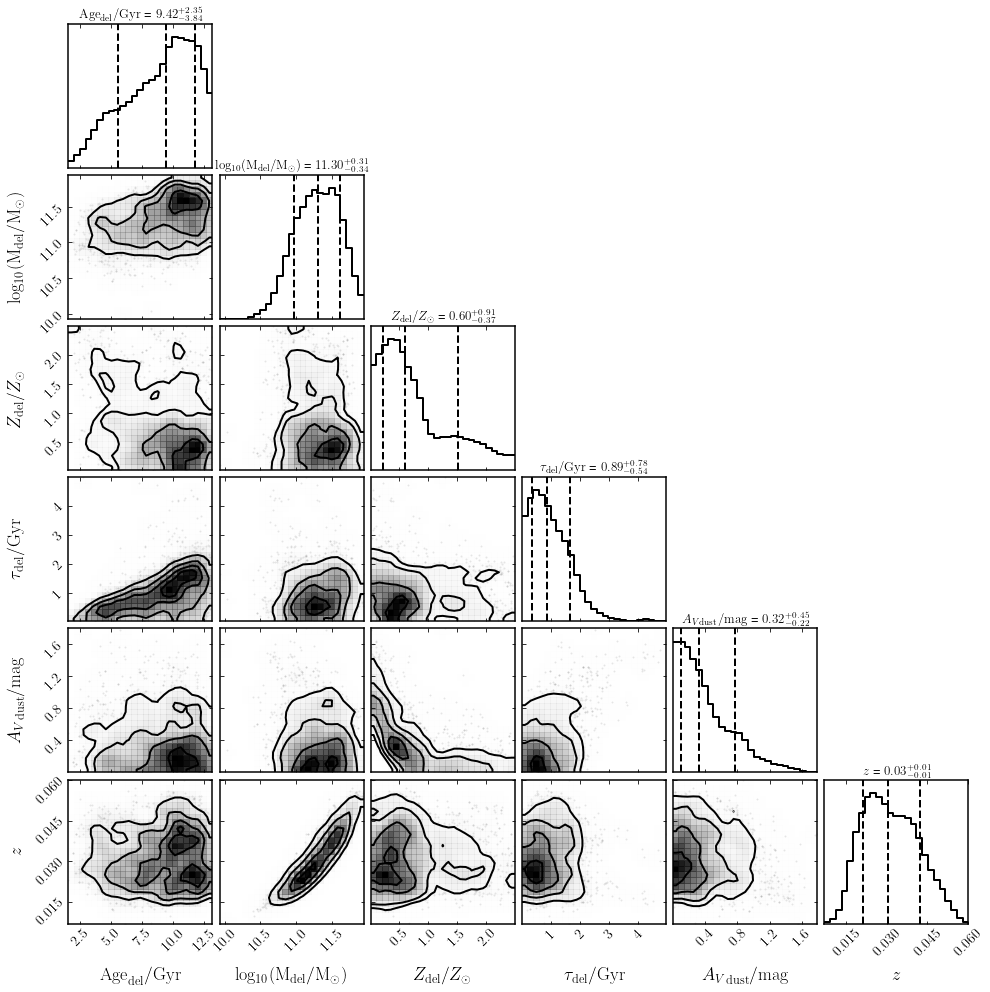

In [14]:
fig=fit.plot_corner(show=True,save=False)